In [1]:
import pandas as pd
import numpy as np
import textstat
from sentence_transformers import SentenceTransformer
import scipy
import nltk
import spacy
import sklearn
import jinja2
import faiss
import chromadb
import torch

print("Todas las dependencias están instaladas correctamente.")

ModuleNotFoundError: No module named 'textstat'

In [1]:
import pandas as pd
from textstat import textstat
from sentence_transformers import SentenceTransformer
import numpy as np
import sys, pandas, textstat, csv, pathlib
print(sys.executable)
print("pandas", pandas.__version__)


ModuleNotFoundError: No module named 'textstat'

In [2]:
df = pd.read_csv("data/quick_scan_rege.csv", sep=';', quotechar='"')
print(df.head(3))
print(df.shape)        # debería dar (155, 4)

FileNotFoundError: [Errno 2] No such file or directory: 'data/quick_scan_rege.csv'

Preparamos cosas y cargamos modelos

In [3]:
# Verificar que el modelo de spaCy esté instalado
import spacy
try:
    nlp = spacy.load('en_core_web_sm')
    print("Modelo 'en_core_web_sm' cargado correctamente.")
except OSError:
    print("Error: Modelo 'en_core_web_sm' no encontrado. Instálalo con 'python -m spacy download en_core_web_sm'")
    raise

Modelo 'en_core_web_sm' cargado correctamente.


In [4]:
# Preparar modelo y cargar módulos
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# Cargar el archivo CSV desde la subcarpeta data
df = pd.read_csv('data/req_ia/quick_scan_template.csv')  # Ajusta la ruta si es necesario
requisitos = df['descripcion'].tolist()  # Usamos solo la columna 'descripcion' para embeddings

# Mostrar los primeros 5 requisitos de forma clara
print("Primeros 5 requisitos cargados:")
for i, req in enumerate(requisitos[:5], 1):  # Mostrar solo los primeros 5
    print(f"{i}. {req}")

# Contar el número total de requisitos (excluyendo el encabezado)
total_requisitos = len(df)  # pandas ya excluye el encabezado al contar las filas
print(f"\nTotal de requisitos procesados: {total_requisitos}")

Primeros 5 requisitos cargados:
1. El sistema debe implementar control de acceso basado en roles (RBAC) para restringir el acceso a la ePHI según el perfil del usuario.
2. El sistema debe autenticar a los usuarios mediante credenciales fuertes con doble factor (2FA).
3. Las sesiones de usuario deben cerrarse automáticamente tras 15 minutos de inactividad.
4. Toda la información ePHI transmitida fuera del entorno seguro debe estar cifrada mediante TLS 1.2 o superior.
5. La base de datos debe cifrar la ePHI en reposo usando AES-256.

Total de requisitos procesados: 155


In [22]:
# Generar embeddings para los requisitos
embeddings = model.encode(requisitos, convert_to_tensor=True)
print(f"Forma de los embeddings: {embeddings.shape}")

NameError: name 'requisitos' is not defined

In [13]:
# Calcular la matriz de similitud coseno
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings.cpu().numpy())
print("Matriz de similitud:")
print(similarity_matrix)

# Guardar la matriz de similitud como archivo .npy (formato binario de NumPy)
np.save('rq5/similarity_matrix.npy', similarity_matrix)
print("Matriz de similitud guardada en 'similarity_matrix.npy'")

# Opcional: Guardar como CSV para inspección manual
pd.DataFrame(similarity_matrix).to_csv('rq5/similarity_matrix.csv', index=False)
print("Matriz de similitud también guardada en 'similarity_matrix.csv'")

Matriz de similitud:
[[1.0000002  0.40722853 0.34949696 ... 0.4994229  0.397402   0.45439985]
 [0.40722853 1.0000001  0.36673617 ... 0.37124532 0.25887415 0.36697945]
 [0.34949696 0.36673617 1.         ... 0.4059996  0.22214265 0.3610472 ]
 ...
 [0.4994229  0.37124532 0.4059996  ... 0.99999976 0.4119932  0.5568082 ]
 [0.397402   0.25887415 0.22214265 ... 0.4119932  1.0000001  0.37671384]
 [0.45439985 0.36697945 0.3610472  ... 0.5568082  0.37671384 1.0000001 ]]
Matriz de similitud guardada en 'similarity_matrix.npy'
Matriz de similitud también guardada en 'similarity_matrix.csv'


In [ ]:
# Identificar pares con alta similitud (por ejemplo, >0.7)
import pandas as pd
import numpy as np

# Cargar la matriz de similitud desde el archivo CSV
similarity_matrix = pd.read_csv('rq5/similarity_matrix.csv').values  # Convierte el CSV a un array NumPy
print("Matriz de similitud cargada (forma:", similarity_matrix.shape, ")")

# Cargar los requisitos originales desde el CSV
df = pd.read_csv('data/req_ia/quick_scan_template.csv')
requisitos = df['descripcion'].tolist()
print("Requisitos cargados:", len(requisitos))

# Crear una lista de pares con alta similitud
high_similarity_pairs = []
for i in range(len(requisitos)):
    for j in range(i + 1, len(requisitos)):  # Evitar comparar un requisito consigo mismo (i != j)
        if similarity_matrix[i][j] > 0.7:  # Umbral ajustable (0.7 como ejemplo)
            high_similarity_pairs.append({
                'Req_1_ID': df['requerimiento_id'][i],  # ID del primer requisito
                'Req_1': requisitos[i],
                'Req_2_ID': df['requerimiento_id'][j],  # ID del segundo requisito
                'Req_2': requisitos[j],
                'Similarity': similarity_matrix[i][j]
            })

# Convertir a DataFrame y guardar
if high_similarity_pairs:
    df_high_similarity = pd.DataFrame(high_similarity_pairs)
    df_high_similarity.to_csv('rq5/high_similarity_pairs.csv', index=False)
    print("Pares con alta similitud guardados en 'rq5/high_similarity_pairs.csv':")
    print(df_high_similarity)

    # Mostrar los 3 pares con mayor similitud
    print("\nTop 3 pares con mayor similitud:")
    top_3_pairs = df_high_similarity.sort_values(by='Similarity', ascending=False).head(3)
    print(top_3_pairs)
else:
    print("No se encontraron pares con similitud mayor a 0.7.")

Matriz de similitud cargada (forma: (155, 155) )
Requisitos cargados: 155
Pares con alta similitud guardados en 'rq5/high_similarity_pairs.csv':
   Req_1_ID                                              Req_1 Req_2_ID  \
0   SIR-001  El sistema debe implementar control de acceso ...  SIR-025   
1   SIR-005  La base de datos debe cifrar la ePHI en reposo...  SIR-116   
2   SIR-006  El sistema debe registrar y auditar todos los ...  SIR-082   
3   SIR-006  El sistema debe registrar y auditar todos los ...  SIR-107   
4   SIR-006  El sistema debe registrar y auditar todos los ...  SIR-128   
5   SIR-006  El sistema debe registrar y auditar todos los ...  SIR-154   
6   SIR-007  Los registros de auditoría deben almacenarse d...  SIR-055   
7   SIR-007  Los registros de auditoría deben almacenarse d...  SIR-082   
8   SIR-007  Los registros de auditoría deben almacenarse d...  SIR-107   
9   SIR-009  El sistema debe contar con un plan documentado...  SIR-155   
10  SIR-010  El sistema debe r

CELDA PARA VISUALIZACION DE LA MATRIZ DE SIMILITUD

In [14]:
import numpy as np

# Cargar la matriz guardada
similarity_matrix = np.load('rq5/similarity_matrix.npy')
print("Forma de la matriz:", similarity_matrix.shape)
print("Primeros 5x5 elementos:")
print(similarity_matrix[:5, :5])  # Muestra solo una parte para no saturar

Forma de la matriz: (155, 155)
Primeros 5x5 elementos:
[[1.0000002  0.40722853 0.34949696 0.42786482 0.22251639]
 [0.40722853 1.0000001  0.36673617 0.43482924 0.29818463]
 [0.34949696 0.36673617 1.         0.352736   0.25215513]
 [0.42786482 0.43482924 0.352736   1.         0.4348535 ]
 [0.22251639 0.29818463 0.25215513 0.4348535  1.0000001 ]]


In [8]:
# Índice de legibilidad
import textstat
def get_legibility_score(text):
    return textstat.flesch_reading_ease(text)

df['legibility_score'] = df['descripcion'].apply(get_legibility_score)
print("Puntuaciones de legibilidad:")
print(df[['requerimiento_id', 'descripcion', 'legibility_score']])

Puntuaciones de legibilidad:
    requerimiento_id                                        descripcion  \
0            SIR-001  El sistema debe implementar control de acceso ...   
1            SIR-002  El sistema debe autenticar a los usuarios medi...   
2            SIR-003  Las sesiones de usuario deben cerrarse automát...   
3            SIR-004  Toda la información ePHI transmitida fuera del...   
4            SIR-005  La base de datos debe cifrar la ePHI en reposo...   
..               ...                                                ...   
150          SIR-151  Todo sistema heredado o sin soporte activo que...   
151          SIR-152  Se debe mantener monitoreo específico sobre lo...   
152          SIR-153  No se deben introducir nuevos datos clínicos s...   
153          SIR-154  Todo acceso a sistemas legados debe registrars...   
154          SIR-155  La continuidad del uso de sistemas legados deb...   

     legibility_score  
0               48.13  
1               40.35 

In [10]:
# Detectar términos ambiguos
import spacy
nlp = spacy.load('en_core_web_sm')
def detect_ambiguous_terms(text):
    doc = nlp(text)
    ambiguous_terms = [token.text for token in doc if token.text.lower() in ['fast', 'quick', 'secure', 'efficient']]
    return ambiguous_terms

In [11]:
df['ambiguous_terms'] = df['descripcion'].apply(detect_ambiguous_terms)
print("Términos ambiguos:")
print(df[['requerimiento_id', 'descripcion', 'ambiguous_terms']])

# Guardar resultados
df.to_csv('checklist_with_analysis.csv', index=False)
print("Análisis guardado en checklist_with_analysis.csv")

Términos ambiguos:
    requerimiento_id                                        descripcion  \
0            SIR-001  El sistema debe implementar control de acceso ...   
1            SIR-002  El sistema debe autenticar a los usuarios medi...   
2            SIR-003  Las sesiones de usuario deben cerrarse automát...   
3            SIR-004  Toda la información ePHI transmitida fuera del...   
4            SIR-005  La base de datos debe cifrar la ePHI en reposo...   
..               ...                                                ...   
150          SIR-151  Todo sistema heredado o sin soporte activo que...   
151          SIR-152  Se debe mantener monitoreo específico sobre lo...   
152          SIR-153  No se deben introducir nuevos datos clínicos s...   
153          SIR-154  Todo acceso a sistemas legados debe registrars...   
154          SIR-155  La continuidad del uso de sistemas legados deb...   

    ambiguous_terms  
0                []  
1                []  
2             

Enfoque final con simlitud entre otros requsitos y legibilidad para decidir calidad de cada requisito


In [4]:
import pandas as pd
import numpy as np

# Cargar la matriz de similitud desde el archivo CSV
similarity_matrix = pd.read_csv('rq5/similarity_matrix.csv').values  # Convierte el CSV a un array NumPy
print("Matriz de similitud cargada (forma:", similarity_matrix.shape, ")")

# Cargar los requisitos originales desde el CSV
df_requisitos = pd.read_csv('rq5/checklist_with_analysis.csv')
requisitos = df_requisitos['descripcion'].tolist()
requerimiento_ids = df_requisitos['requerimiento_id'].tolist()
print("Requisitos cargados:", len(requisitos))

# Calcular la similitud máxima para cada requisito
similitud_maxima_list = []
for i in range(len(requisitos)):
    max_sim = 0.0
    similar_id_idx = None
    for j in range(len(requisitos)):
        if i != j:  # Evitar comparar un requisito consigo mismo
            if similarity_matrix[i][j] > max_sim:
                max_sim = similarity_matrix[i][j]
                similar_id_idx = j
    similar_id = requerimiento_ids[similar_id_idx] if similar_id_idx is not None else "N/A"
    similitud_maxima_list.append(f"{max_sim:.2f}-{similar_id}")

# Añadir la columna de similitud máxima al DataFrame
df_requisitos['similitud_maxima'] = similitud_maxima_list

# Seleccionar solo las columnas requeridas
df_output = df_requisitos[['requerimiento_id', 'descripcion', 'legibility_score', 'similitud_maxima']]

# Guardar el resultado en un nuevo CSV
df_output.to_csv('rq5/requisitos_analisis_simiYlegi.csv', index=False)
print("CSV generado como 'rq5/requisitos_analisis_simiYlegi.csv' con similitud máxima y puntuación de legibilidad.")

Matriz de similitud cargada (forma: (155, 155) )
Requisitos cargados: 155
CSV generado como 'rq5/requisitos_analisis_simiYlegi.csv' con similitud máxima y puntuación de legibilidad.


PROCESO DE VALIDACION REQUISITOS EXPERTO


In [9]:
import pandas as pd

# Leer el archivo CSV con coma como separador y comillas como quotechar
df = pd.read_csv("data/req_human/checklist_human.csv", sep=',', quotechar='"')
print(df.head(3))
print(df.shape)

                ID                                        Descripción
0  SEC-CAT-BAC-001  The application will implement and apply dual ...
1  SEC-CAT-BAC-002  The application must incorporate robust access...
2  SEC-CAT-BAC-003  The application must implement security measur...
(140, 2)


In [10]:
# Cargar el archivo CSV desde la subcarpeta data
df = pd.read_csv('data/req_human/checklist_human.csv')  # Ajusta la ruta si es necesario
requisitos_ex = df['Descripción'].tolist()  # Usamos solo la columna 'descripcion' para embeddings

# Mostrar los primeros 5 requisitos de forma clara
print("Primeros 5 requisitos cargados:")
for i, req in enumerate(requisitos_ex[:5], 1):  # Mostrar solo los primeros 5
    print(f"{i}. {req}")

# Contar el número total de requisitos (excluyendo el encabezado)
total_requisitos_ex = len(df)  # pandas ya excluye el encabezado al contar las filas
print(f"\nTotal de requisitos procesados: {total_requisitos_ex}")

Primeros 5 requisitos cargados:
1. The application will implement and apply dual access control prior to deleting users, medical records.
2. The application must incorporate robust access control mechanisms to prevent circumvention of access control checks by manipulating the URL. The following access control bypass tactics should be avoided and counteracted: 1. Modification of the URL (parameter manipulation or forced navigation). 2. Modification of the internal state of the application. 3. Modification of the HTML page. 4. Use of attack tools to modify API requests
3. The application must implement security measures to prevent the elevation of privileges. Prevent situations where a user can act without being authenticated or an administrator can act as a regular user after logging in.
4. The application must enforce strict and flexible access controls for authorized users, preventing unauthorized access to the API and ensuring record ownership.
5. The application must prevent unautho

In [11]:
# Generar embeddings para los requisitos
embeddings = model.encode(requisitos_ex, convert_to_tensor=True)
print(f"Forma de los embeddings: {embeddings.shape}")

Forma de los embeddings: torch.Size([140, 384])


In [17]:
# Calcular la matriz de similitud coseno
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix_ex = cosine_similarity(embeddings.cpu().numpy())
print("Matriz de similitud requisitos del experto:")
print(similarity_matrix_ex)

# Guardar la matriz de similitud como archivo .npy (formato binario de NumPy)
np.save('data/req_human/results/similarity_matrix_ex.npy', similarity_matrix_ex)
print("Matriz de similitud guardada en 'similarity_matrix_ex.npy'")

# Opcional: Guardar como CSV para inspección manual
pd.DataFrame(similarity_matrix_ex).to_csv('data/req_human/results/similarity_matrix_ex.csv', index=False)
print("Matriz de similitud también guardada en 'similarity_matrix_ex.csv'")
print("Forma de la matriz:", similarity_matrix_ex.shape)

Matriz de similitud requisitos del experto:
[[1.0000001  0.34413946 0.5156945  ... 0.56703955 0.27589935 0.28998715]
 [0.34413946 0.9999999  0.5259344  ... 0.22573426 0.21686229 0.39771974]
 [0.5156945  0.5259344  0.99999994 ... 0.37666506 0.3836211  0.44831765]
 ...
 [0.56703955 0.22573426 0.37666506 ... 1.0000002  0.35026604 0.23847115]
 [0.27589935 0.21686229 0.3836211  ... 0.35026604 1.0000001  0.3399395 ]
 [0.28998715 0.39771974 0.44831765 ... 0.23847115 0.3399395  1.        ]]
Matriz de similitud guardada en 'similarity_matrix_ex.npy'
Matriz de similitud también guardada en 'similarity_matrix_ex.csv'
Forma de la matriz: (140, 140)


UNA VEZ TENEMOS LA MATRIZ DE SIMILITUD PARA LOS REQUISITOS DEL EXPERTO 
PASAMOS A CALCULAR LOS PARES MAS SIMILARES DE DICHA MATRIZ 
FUSIONARLO CON EL CALCULO DE LA LEGIBILIDAD

In [18]:
import pandas as pd
import numpy as np
import textstat

# Cargar la matriz de similitud desde el archivo .npy (más precisa que CSV)
similarity_matrix = np.load('data/req_human/results/similarity_matrix_ex.npy')
print("Matriz de similitud cargada (forma:", similarity_matrix.shape, ")")

# Cargar los requisitos originales desde el CSV de los expertos
df = pd.read_csv('data/req_human/checklist_human.csv')
requisitos = df['Descripción'].tolist()
requerimiento_ids = df['ID'].tolist()
print("Requisitos cargados:", len(requisitos))

# Crear una lista de pares con alta similitud
high_similarity_pairs = []
for i in range(len(requisitos)):
    for j in range(i + 1, len(requisitos)):  # Evitar comparar un requisito consigo mismo
        if similarity_matrix[i][j] > 0.7:  # Umbral ajustable (0.7 como ejemplo)
            high_similarity_pairs.append({
                'Req_1_ID': requerimiento_ids[i],
                'Req_1': requisitos[i],
                'Req_2_ID': requerimiento_ids[j],
                'Req_2': requisitos[j],
                'Similarity': similarity_matrix[i][j]
            })

# Convertir a DataFrame y guardar pares con alta similitud
if high_similarity_pairs:
    df_high_similarity = pd.DataFrame(high_similarity_pairs)
    df_high_similarity.to_csv('data/req_human/results/high_similarity_pairs_ex.csv', index=False)
    print("Pares con alta similitud guardados en 'data/req_human/results/high_similarity_pairs_ex.csv':")
    print(df_high_similarity)

    # Mostrar los 3 pares con mayor similitud
    print("\nTop 3 pares con mayor similitud:")
    top_3_pairs = df_high_similarity.sort_values(by='Similarity', ascending=False).head(3)
    print(top_3_pairs)
else:
    print("No se encontraron pares con similitud mayor a 0.7.")

# Definir función para calcular el índice de legibilidad (Flesch Reading Ease)
def get_legibility_score(text):
    """
    Calcula el índice de legibilidad Flesch Reading Ease para un texto en inglés.
    - Retorna un puntaje entre 0 y 100: mayor puntaje = más fácil de leer.
    - Basado en la longitud de palabras y oraciones.
    """
    return textstat.flesch_reading_ease(text)

# Calcular puntuaciones de legibilidad para cada requisito
df['Legibility_Score'] = df['Descripción'].apply(get_legibility_score)
print("Puntuaciones de legibilidad calculadas:")
print(df[['ID', 'Descripción', 'Legibility_Score']].head())  # Mostrar las primeras 5 filas como ejemplo

# Combinar resultados en un DataFrame
df_analysis = pd.DataFrame({
    'ID': requerimiento_ids,
    'Descripción': requisitos,
    'Legibility_Score': df['Legibility_Score'].tolist()  # Usar las puntuaciones calculadas
})

# Añadir la similitud máxima para cada requisito
max_similarity = []
for i in range(len(requisitos)):
    max_sim = 0.0
    similar_id_idx = None
    for j in range(len(requisitos)):
        if i != j and similarity_matrix[i][j] > max_sim:
            max_sim = similarity_matrix[i][j]
            similar_id_idx = j
    similar_id = requerimiento_ids[similar_id_idx] if similar_id_idx is not None else "N/A"
    max_similarity.append(f"{max_sim:.2f}-{similar_id}")

df_analysis['Max_Similarity'] = max_similarity

# Guardar el análisis combinado
df_analysis.to_csv('data/req_human/results/expert_analisis_simiYlegi.csv', index=False)
print("Análisis combinado guardado en 'data/req_human/results/expert_analisis_simiYlegi.csv'")

Matriz de similitud cargada (forma: (140, 140) )
Requisitos cargados: 140
Pares con alta similitud guardados en 'data/req_human/results/high_similarity_pairs_ex.csv':
           Req_1_ID                                              Req_1  \
0   SEC-CAT-BAC-003  The application must implement security measur...   
1   SEC-CAT-BAC-005  The application must prevent unauthorized acce...   
2   SEC-CAT-BAC-005  The application must prevent unauthorized acce...   
3   SEC-CAT-BAC-005  The application must prevent unauthorized acce...   
4   SEC-CAT-CRF-002  The application must ensure the security of in...   
5   SEC-CAT-CRF-002  The application must ensure the security of in...   
6   SEC-CAT-CRF-002  The application must ensure the security of in...   
7   SEC-CAT-IND-021  The application must implement repetition-resi...   
8   SEC-CAT-IND-024  Safe messages with WS-Security must have time ...   
9   SEC-CAT-SEM-007  The application must identify and authenticate...   
10  SEC-CAT-SEM-012

PROCESO DE OBTENCION DE RESULTADOS DEL ANALISIS CRUZADO POR GROK ENTRE MODELO DE NOTEBOOK Y AGENTE DE CHATGPT PARA REQUISITOS DE LA IA

In [10]:
# Celda 1: Preprocesar el archivo CSV con corrección de campos
import csv

# Abrir el archivo original y crear uno nuevo
with open('rq5/RQ5-AnalisisCruzadoNote-IA.csv', 'r', encoding='utf-8') as infile, \
     open('rq5/RQ5-AnalisisCruzadoNote-IA_cleaned.csv', 'w', newline='', encoding='utf-8') as outfile:

    reader = csv.reader(infile, quotechar='"', delimiter=',', skipinitialspace=True)
    writer = csv.writer(outfile, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, escapechar='\\')

    # Escribir el encabezado
    header = next(reader)
    writer.writerow(header)

    # Procesar cada línea
    for row in reader:
        if len(row) < 8:
            print(f"Error: Línea con menos de 8 campos: {row}")
            continue
        elif len(row) > 8:
            print(f"Corriendo línea con {len(row)} campos: {row}")
            # Reconstruir los campos de forma dinámica
            id_val = row[0]  # ID
            req_gen = ' '.join(row[1:4]).strip()  # Unir Requisito generado (hasta 3 elementos si es necesario)
            art_fuente = ', '.join(row[4:7]) if len(row) >= 7 else row[4] if len(row) > 4 else ''  # Artículo/Fuente
            extraido = row[7] if len(row) > 7 else 'Sí'  # ¿Extraído correctamente?
            nivel = row[8] if len(row) > 8 else 'Alta'  # Nivel de fidelidad
            tipo_error = row[9] if len(row) > 9 else ''  # Tipo de error
            porc_calidad = row[-1]  # Porcentaje de calidad (último elemento)
            justif = ' '.join(row[10:-1]).strip() if len(row) > 10 else row[10] if len(row) > 10 else ''  # Justificación/Comentarios

            # Asegurarse de que justif no cause error si row[-1] ya fue tomado
            if not justif and len(row) > 10:
                justif = ' '.join(row[10:]).strip().rsplit(' ', 1)[0]  # Tomar todo menos el último (porc_calidad)

            # Escribir la línea corregida
            writer.writerow([id_val, req_gen, art_fuente, extraido, nivel, tipo_error, justif, porc_calidad])
        else:
            writer.writerow(row)

print("Archivo preprocesado guardado como 'rq5/RQ5-AnalisisCruzadoNote-IA_cleaned.csv'")

Corriendo línea con 12 campos: ['SIR-001', 'El sistema debe implementar control de acceso basado en roles (RBAC) para restringir el acceso a la ePHI según el perfil del usuario.', 'NIST SP 800-53 Rev.5 AC-3', 'ISO 27002:2022 5.15', 'HIPAA 45 CFR §164.312(a)(1)', 'Sí', 'Alta', '', 'Clara', 'sin ambigüedad. Correctamente alineada con AC-3 (RBAC)', 'ISO 27002:2022 y HIPAA.', '67']
Corriendo línea con 11 campos: ['SIR-002', 'El sistema debe autenticar a los usuarios mediante credenciales fuertes con doble factor (2FA).', 'NIST SP 800-53 Rev.5 IA-2(1)', 'ISO 27002:2022 5.17', 'DISA STIG V-222390', 'Sí', 'Alta', '', 'Bien trazado. IA-2(1) exige autenticación multifactor', 'ISO y STIG lo refuerzan. Especificado con ejemplos (OTP/FIDO2) y evaluable.', '64']
Corriendo línea con 12 campos: ['SIR-003', 'Las sesiones de usuario deben cerrarse automáticamente tras 15 minutos de inactividad.', 'HIPAA 45 CFR §164.312(b)', 'DISA STIG V-222389', 'NIST AC-12', 'Sí', 'Alta', '', 'Fidelidad normativa comp

In [8]:
# Celda 2: Analizar el archivo corregido
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo corregido
df = pd.read_csv('rq5_results/RQ5-AnalisisCruzadoNote-IA-BUENO.csv', quotechar='"')

# Calcular métricas básicas
media_calidad = df['Porcentaje de calidad'].mean()
max_calidad = df['Porcentaje de calidad'].max()
min_calidad = df['Porcentaje de calidad'].min()
requisito_max = df[df['Porcentaje de calidad'] == max_calidad]['ID'].iloc[0]
requisito_min = df[df['Porcentaje de calidad'] == min_calidad]['ID'].iloc[0]

# Resumen de calidad general
print("### Resumen de Calidad de los Requisitos")
print(f"- Media del porcentaje de calidad: {media_calidad:.2f}%")
print(f"- Requisito con mayor calidad ({max_calidad}%): {requisito_max}")
print(f"- Requisito con menor calidad ({min_calidad}%): {requisito_min}")

# Seleccionar los 5 requisitos de mayor y menor calidad
top_5 = df.nlargest(5, 'Porcentaje de calidad')[['ID', 'Porcentaje de calidad']]
bottom_5 = df.nsmallest(5, 'Porcentaje de calidad')[['ID', 'Porcentaje de calidad']]

# Imprimir los datos seleccionados para depuración
print("Top 5:", top_5)
print("Bottom 5:", bottom_5)

# Visualización: Gráfico de barras con los 5 requisitos de mayor y menor calidad
plt.figure(figsize=(10, 5))
plt.bar(top_5['ID'], top_5['Porcentaje de calidad'], color='green', label='Top 5')
plt.bar(bottom_5['ID'], bottom_5['Porcentaje de calidad'], color='red', label='Bottom 5')
plt.axhline(y=media_calidad, color='blue', linestyle='--', label=f'Media: {media_calidad:.2f}%')
plt.title('Top 5 y Bottom 5 Requisitos por Calidad - Requisitos Agente IA')
plt.xlabel('ID del Requisito')
plt.ylabel('Porcentaje de Calidad (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'rq5_results/RQ5-AnalisisCruzadoNote-IA-BUENO.csv'

PROCESO DE OBTENCION DE RESULTADOS DEL ANALISIS CRUZADO POR GROK ENTRE MODELO DE NOTEBOOK Y AGENTE DE CHATGPT PARA REQUISITOS DEL EXPERTO

In [14]:
import csv

# Abrir el archivo original y crear uno nuevo
with open('data/req_human/results/RQ5-AnalisisCruzadoNote-IA-Expertos.csv', 'r', encoding='utf-8') as infile, \
     open('rq5_results/Result_req_Experto/RQ5-AnalisisCruzadoNote-IA-Expertos.csv', 'w', newline='', encoding='utf-8') as outfile:

    reader = csv.reader(infile, quotechar='"', delimiter=',', skipinitialspace=True)
    writer = csv.writer(outfile, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, escapechar='\\')

    # Escribir el encabezado
    header = next(reader)
    writer.writerow(header)

    # Procesar cada línea
    for row in reader:
        if len(row) < 10:
            print(f"Error: Línea con menos de 10 campos: {row}")
            continue
        elif len(row) > 10:
            print(f"Corriendo línea con {len(row)} campos: {row}")
            # Reconstruir los campos de forma dinámica
            id_val = row[0]  # ID
            req_gen = ' '.join(row[1:3]).strip()  # Unir Requisito generado (columnas 1 y 2)
            art_fuente = row[3] if len(row) > 3 else ''  # Artículo/Fuente
            extraido = row[4] if len(row) > 4 else 'Sí'  # ¿Extraído correctamente?
            justif = row[5] if len(row) > 5 else ''  # Justificación/Comentarios
            nivel = row[6] if len(row) > 6 else 'Alta'  # Nivel de fidelidad
            tipo_error = row[7] if len(row) > 7 else ''  # Tipo de error (si aplica)
            legibility = row[8] if len(row) > 8 else ''  # Legibility_Score
            max_sim = row[9] if len(row) > 9 else ''  # Max_Similarity
            porc_calidad = row[10] if len(row) > 10 else ''  # Porcentaje de Calidad

            # Ajustar justificación si hay desbordamiento
            if len(row) > 11:
                justif += ' ' + ' '.join(row[11:]).strip().rsplit(',', 1)[0]

            # Escribir la línea corregida
            writer.writerow([id_val, req_gen, art_fuente, extraido, justif, nivel, tipo_error, legibility, max_sim, porc_calidad])
        else:
            writer.writerow(row)

print("Archivo preprocesado guardado como 'expert_requirements_analysis_cleaned.csv'")

Archivo preprocesado guardado como 'expert_requirements_analysis_cleaned.csv'


### Resumen de Calidad de los Requisitos
- Media del porcentaje de calidad: 59.53%
- Requisito con mayor calidad (86.82%): SEC-CAT-IAF-028
- Requisito con menor calidad (33.33%): SEC-CAT-SEM-005
Top 5:                  ID  Porcentaje de Calidad
88  SEC-CAT-IAF-028                  86.82
95  SEC-CAT-IAF-035                  84.74
77  SEC-CAT-IAF-017                  82.45
78  SEC-CAT-IAF-018                  81.95
82  SEC-CAT-IAF-022                  81.35
Bottom 5:                   ID  Porcentaje de Calidad
48   SEC-CAT-SEM-005                  33.33
108  SEC-CAT-LMF-002                  33.40
91   SEC-CAT-IAF-031                  34.15
104  SEC-CAT-SDF-005                  35.43
94   SEC-CAT-IAF-034                  36.46


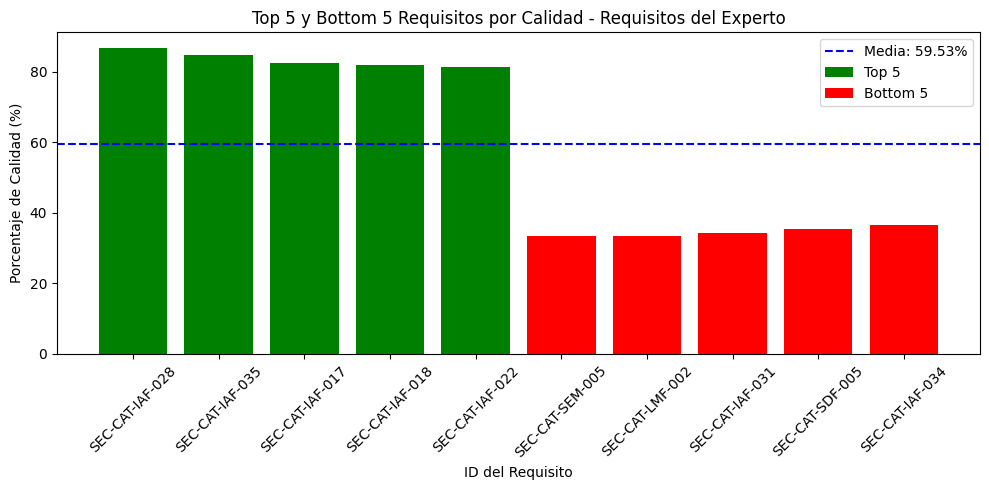

In [13]:
# Celda 2: Analizar el archivo corregido
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo corregido
df = pd.read_csv('rq5_results/Result_req_Experto/RQ5-AnalisisCruzadoNote-IA-Expertos.csv', quotechar='"')

# Calcular métricas básicas
media_calidad = df['Porcentaje de Calidad'].mean()
max_calidad = df['Porcentaje de Calidad'].max()
min_calidad = df['Porcentaje de Calidad'].min()
requisito_max = df[df['Porcentaje de Calidad'] == max_calidad]['ID'].iloc[0]
requisito_min = df[df['Porcentaje de Calidad'] == min_calidad]['ID'].iloc[0]

# Resumen de calidad general
print("### Resumen de Calidad de los Requisitos")
print(f"- Media del porcentaje de calidad: {media_calidad:.2f}%")
print(f"- Requisito con mayor calidad ({max_calidad}%): {requisito_max}")
print(f"- Requisito con menor calidad ({min_calidad}%): {requisito_min}")

# Seleccionar los 5 requisitos de mayor y menor calidad
top_5 = df.nlargest(5, 'Porcentaje de Calidad')[['ID', 'Porcentaje de Calidad']]
bottom_5 = df.nsmallest(5, 'Porcentaje de Calidad')[['ID', 'Porcentaje de Calidad']]

# Imprimir los datos seleccionados para depuración
print("Top 5:", top_5)
print("Bottom 5:", bottom_5)

# Visualización: Gráfico de barras con los 5 requisitos de mayor y menor calidad
plt.figure(figsize=(10, 5))
plt.bar(top_5['ID'], top_5['Porcentaje de Calidad'], color='green', label='Top 5')
plt.bar(bottom_5['ID'], bottom_5['Porcentaje de Calidad'], color='red', label='Bottom 5')
plt.axhline(y=media_calidad, color='blue', linestyle='--', label=f'Media: {media_calidad:.2f}%')
plt.title('Top 5 y Bottom 5 Requisitos por Calidad - Requisitos del Experto')
plt.xlabel('ID del Requisito')
plt.ylabel('Porcentaje de Calidad (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()